# CEWA 568 Snow Hydrology - Spring 2023
## Homework 5: Radiation, albedo, and the energy balance 

Daniel Hogan

---

In [1]:
from pysolar.solar import *
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json
import pytz

In [2]:
### Functions
'''
radsys_grabber.py

Given a start and end date, this will load radys data into an xarray dataset
'''

def get_daily_radsys_data(start, end):
    # url to request from
    base_url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/'

    # format dates
    if not isinstance(start, dt.date): 
        start = dt.datetime.strptime(start,'%Y-%m-%d')
    if not isinstance(end, dt.date): 
        end = dt.datetime.strptime(end ,'%Y-%m-%d')

    # get time delta    
    delta = end - start
    
    dates = []
    for i in range(delta.days + 1):
        dates.append(start + dt.timedelta(days=i))

    url_list = []
    for date in dates:
        if date.timetuple().tm_yday < 10:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}00{date.timetuple().tm_yday}.dat')
        elif date.timetuple().tm_yday < 100:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}0{date.timetuple().tm_yday}.dat')
        else: 
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}{date.timetuple().tm_yday}.dat')
    datasets = []
    for fn in url_list:
        # read in data
        print(f'Grabbing {fn}...')
        try:
            ckp_df = pd.read_csv(fn, 
                                skiprows=2, 
                                header=None, 
                                delim_whitespace=True, 
                                parse_dates={'time':[0,2,3,4,5]}, 
                                infer_datetime_format=True)
            datasets.append(met_data_formatting(ckp_df))
            print('Done!')
        except:
            print('File not found... skipping...')
            pass
    radsys_ds = xr.concat(datasets, dim='time')
    radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                       'no_data': -9999.9,
                       'time':'UTC',
                       'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                       'datastreamname':'Radsys'})
    # add a coordinate with LocalTime for Plotting
    # time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
    # us_mtn = pytz.timezone('US/Mountain')
    # tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    # local_da=xr.DataArray.from_series(tz_corrected)
    # radsys_ds.coords.update({'local_time':tz_corrected})


    with open('radsys_attributes.txt', 'r') as j:
        attribute_dict = json.loads(j.read())
    for variable in radsys_ds.variables:
        if variable in attribute_dict.keys():
            radsys_ds[variable].attrs.update(attribute_dict[variable])
    return radsys_ds

def met_data_formatting(ckp_df):
    
    # Convert DateTime column to datetime
    ckp_df['time'] = pd.to_datetime(ckp_df['time'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [f'{col_name}_qc' for col_name in ckp_df.columns[4::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names)))

    ckp_ds = ckp_df.set_index('time', drop=True).to_xarray()
    return ckp_ds

### Problem 1: Comparing solar radiation sensors
A common problem in mountain snow energy balance studies is that snow accumulates on the upward pointing radiometers. Find a time in our dataset when you think this occurred and explain your reasoning. Hint, you may want to look at the precipitation dataset in Lab 2 for timing. Which radiometer set-up (SOS or SPLASH) worked better during your timeperiod? Why do you think this is? Compare downwelling and reflected shortwave radiation with potential shortwave radiation for your day.

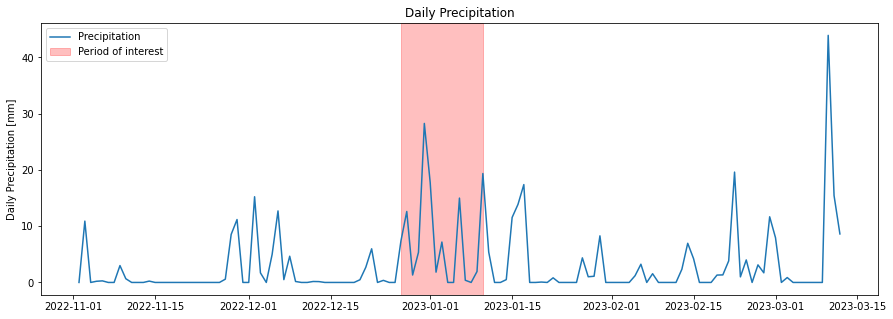

In [3]:
# First we will plot the precipitation time series to look at when the upward pointing radiometers may be comprimized 
precip = xr.open_dataset(f"../data/precipitation.nc")

# Precipitation
daily_precip = precip['acc_prec'].diff(dim='date').to_series()
daily_precip.index = precip['acc_prec'].diff(dim='date').to_series().index.date
ax = daily_precip.plot(figsize=(15,5), label='Precipitation')
# xticks = daily_precip.index
# ax.set_xticklabels(xticks,rotation=90)
ax.axvspan(dt.date(2022,12,27),dt.date(2023,1,10), alpha=0.25, color='red', label='Period of interest')
ax.set_title('Daily Precipitation')
ax.set_ylabel('Daily Precipitation [mm]')
ax.legend()

I will focus my time period on the early parts of 2023 because we will have minimal solar energy available to melt snow off radiometers since we are near the soltice and we had plenty of snow falling over this period relatively continuously.

In [4]:
datelist = [dt.datetime.strftime(date, format='%Y%m%d') for date in pd.date_range('20221227','20230110', freq='D')]

sos_datasets = [xr.open_dataset(f'../data/sosnoqc/isfs_{date}.nc') for date in datelist]
sos_ds = xr.concat(sos_datasets, dim='time')

In [5]:
### Calculate longwave and filter dataset
SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
sos_ds = sos_ds.assign(LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),
              LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA))
VARIABLES = ['Rsw_in_9m_d',
            'Rsw_out_9m_d',
            'LWout',
            'LWin']

sos_seb_ds = sos_ds[VARIABLES]

time_utc = sos_seb_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
sos_seb_ds.coords.update({'LocalTime':tz_corrected})

In [6]:
radsys_ds = get_daily_radsys_data('2022-12-27','2023-01-10')

Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22361.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22362.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22363.dat...
File not found... skipping...
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22364.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22365.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23001.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23002.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23003.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23004.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23005.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiat

In [7]:
# Add local time
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'LocalTime':tz_corrected})

In [66]:
### Import modeled clear sky radiation
kettle_ponds_lat_lon = [-106.97298,38.94182]
dates = pd.date_range(dt.datetime(2022,12,27,0,0),dt.datetime(2023,1,11,0,0),  freq='1H', tz='UTC')

clear_sky_rad = []
for date in dates:
    date = (date).to_pydatetime()
    altitude_deg = get_altitude(kettle_ponds_lat_lon[1], kettle_ponds_lat_lon[0], date,
                                elevation=2657,
                                temperature=263.15,
                                pressure=71000.0,)
    clear_sky_rad.append(radiation.get_radiation_direct(date, altitude_deg)*3/5)
clear_sky_rad_df = pd.Series(clear_sky_rad, index=dates)

c:\Users\dlhogan\anaconda3\envs\radiative_transfer\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


In [ ]:
from pyclearsky import clearskyrad

Text(0.5, 1.0, 'SOS Surface Energy Balance')

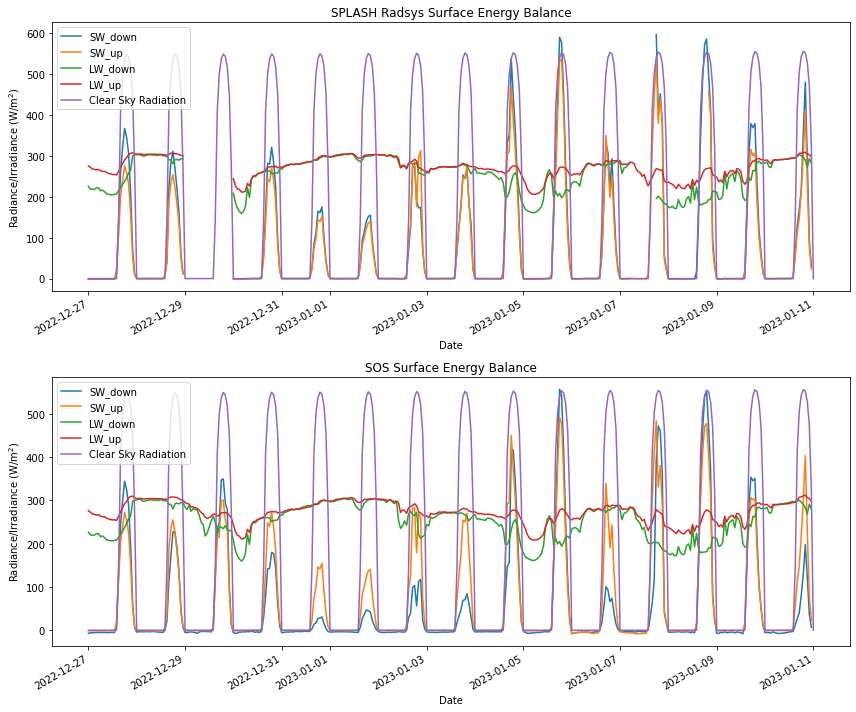

In [76]:
### Now lets plot out time series
fig, axs = plt.subplots(nrows=2, figsize=(12,10), tight_layout=True)



# Radsys plot
radsys_ds.where(radsys_ds['dw_solar_qc'] == 0).resample(time='1H').mean()['dw_solar'].plot(ax=axs[0], label='SW_down')
(radsys_ds.where(radsys_ds['uw_solar_qc'] == 0).resample(time='1H').mean()['uw_solar']).plot(ax=axs[0], label='SW_up')
radsys_ds.where(radsys_ds['dw_ir_qc'] == 0).resample(time='1H').mean()['dw_ir'].plot(ax=axs[0], label='LW_down')
(radsys_ds.where(radsys_ds['uw_ir_qc'] == 0).resample(time='1H').mean()['uw_ir']).plot(ax=axs[0], label='LW_up')

clear_sky_rad_df.plot(ax=axs[0], label='Clear Sky Radiation')
axs[0].legend()

# SOS Plot
time_period = slice('2022-12-27','2023-01-10')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['Rsw_in_9m_d'].plot(ax=axs[1], label='SW_down')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['Rsw_out_9m_d'].plot(ax=axs[1], label='SW_up')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['LWin'].plot(ax=axs[1], label='LW_down')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['LWout'].plot(ax=axs[1], label='LW_up')

clear_sky_rad_df.plot(ax=axs[1], label='Clear Sky Radiation')
axs[1].legend()

# Formatting
axs[1].set_xlabel('Date')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Radiance/Irradiance (W/m$^2$)')
axs[1].set_ylabel('Radiance/Irradiance (W/m$^2$)')
axs[0].set_title('SPLASH Radsys Surface Energy Balance')
axs[1].set_title('SOS Surface Energy Balance')

### Now lets close in on the period around the new year

Text(0.5, 1.0, 'SOS Surface Energy Balance')

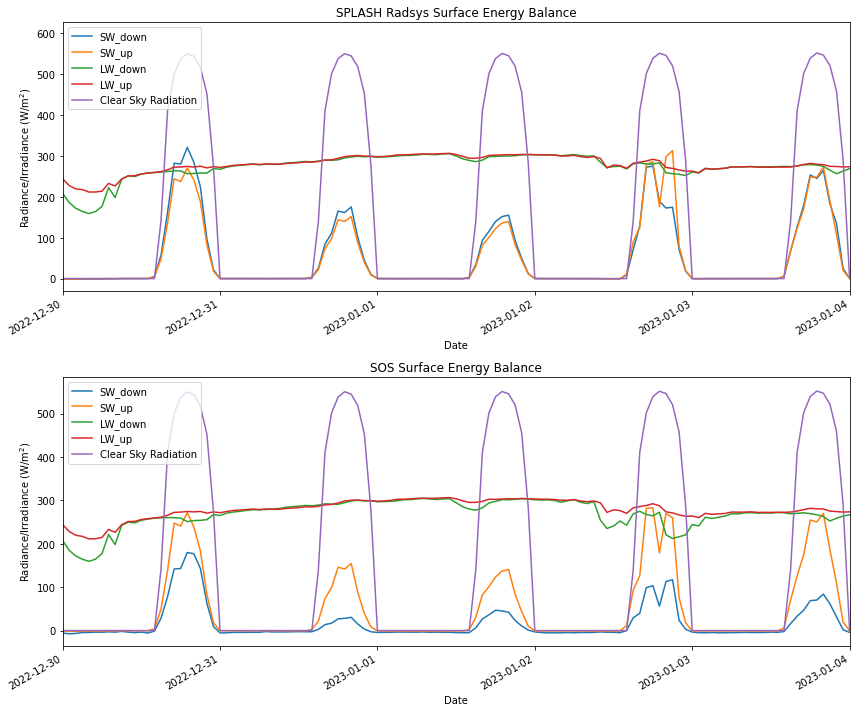

In [75]:
### Now lets plot out time series
fig, axs = plt.subplots(nrows=2, figsize=(12,10), tight_layout=True)



# Radsys plot
radsys_ds.where(radsys_ds['dw_solar_qc'] == 0).resample(time='1H').mean()['dw_solar'].plot(ax=axs[0], label='SW_down')
(radsys_ds.where(radsys_ds['uw_solar_qc'] == 0).resample(time='1H').mean()['uw_solar']).plot(ax=axs[0], label='SW_up')
radsys_ds.where(radsys_ds['dw_ir_qc'] == 0).resample(time='1H').mean()['dw_ir'].plot(ax=axs[0], label='LW_down')
(radsys_ds.where(radsys_ds['uw_ir_qc'] == 0).resample(time='1H').mean()['uw_ir']).plot(ax=axs[0], label='LW_up')

clear_sky_rad_df.plot(ax=axs[0], label='Clear Sky Radiation')
axs[0].legend()
axs[0].set_xlim(dt.date(2022,12,30),dt.date(2023,1,4))
# SOS Plot
time_period = slice('2022-12-30','2023-01-04')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['Rsw_in_9m_d'].plot(ax=axs[1], label='SW_down')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['Rsw_out_9m_d'].plot(ax=axs[1], label='SW_up')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['LWin'].plot(ax=axs[1], label='LW_down')
sos_seb_ds.sel(time=time_period).resample(time='1H').mean()['LWout'].plot(ax=axs[1], label='LW_up')

clear_sky_rad_df.plot(ax=axs[1], label='Clear Sky Radiation')
axs[1].legend()
axs[1].set_xlim(dt.date(2022,12,30),dt.date(2023,1,4))

# Formatting
axs[1].set_xlabel('Date')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Radiance/Irradiance (W/m$^2$)')
axs[1].set_ylabel('Radiance/Irradiance (W/m$^2$)')
axs[0].set_title('SPLASH Radsys Surface Energy Balance')
axs[1].set_title('SOS Surface Energy Balance')

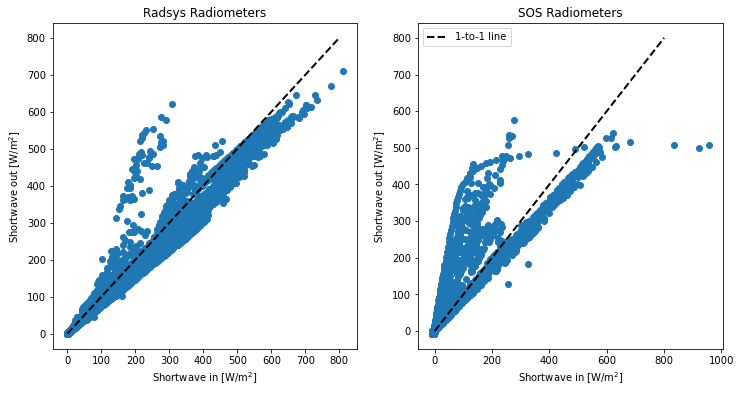

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].scatter(radsys_ds.where(radsys_ds['dw_solar_qc'] == 0)['dw_solar'],
            radsys_ds.where(radsys_ds['uw_solar_qc'] == 0)['uw_solar'])
axs[0].plot([0,800],[0,800],label='1-to-1 line', lw=2, color='k',ls='--')
axs[0].set_xlabel('Shortwave in [W/m$^2$]')
axs[0].set_ylabel('Shortwave out [W/m$^2$]')
axs[0].set_title('Radsys Radiometers')

axs[1].scatter(sos_seb_ds.sel(time=time_period)['Rsw_in_9m_d'],
            sos_seb_ds.sel(time=time_period)['Rsw_out_9m_d'])
axs[1].plot([0,800],[0,800],label='1-to-1 line', lw=2, color='k',ls='--')
axs[1].set_xlabel('Shortwave in [W/m$^2$]')
axs[1].set_ylabel('Shortwave out [W/m$^2$]')
axs[1].set_title('SOS Radiometers')
axs[1].legend()

Over this period, we can see an the SOS radiometers had more trouble with snow on the radiometers. The plots above show that a good amount of time at incoming shortwave radiation less than outgoing shortwave radiation. While snow does have a high albedo, there is no way that shortwave radiation could increase after reflecting off the surface, so the likely culprit is snow covering the radiometers. The radsys still shows periods where shortwave out is greater than shortwave in, but it happens much less. One reason for this may be the fact that the Radsys table is accessible by simply walking to it and clearing snow off the radiometer, whereas the SOS radiometers are 9 meters above the surface and much harder to clear regularly. 

For potential shortwave, I think the model I am using is providing a value that is too high. At this location and during this time, the peak clear sky radiation should be around 500-600 W/m2 (using this pyranometer validation model for clear sky radiation: https://clearskycalculator.com/pyranometer.htm), but unscaled values are near 800-900 W/m2. To get a more reasonable value, I scaled the potential shortwaver radiation by 3/5 to get within the range of reasonable values. Additionally, this model does not take into account local topography, so a clear sky radiation model specific to this location would be needed to provide a better comparison. However, this model does allow us to see that the observed shortwave radiation is not close to the clear sky radiation since plenty of clouds are present during the stormy period.

### Problem 2: Clouds
Identify a period of variable cloud cover in the dataset. Explain how you can use both shortwave and longwave measurements to identify variations in clouds. include periods from both day and nighttime hours. How are the shortwave and longwave datasets complimentary? Do they tell you the same or different information about the clouds?

From Week 11 of the weather blog (Jan 2 through Jan 8), cloud cover was variable for much of this period, so I will use that time to focus on for this questions

Text(0.5, 1.0, 'Radiation measurements from SOS Radiometers')

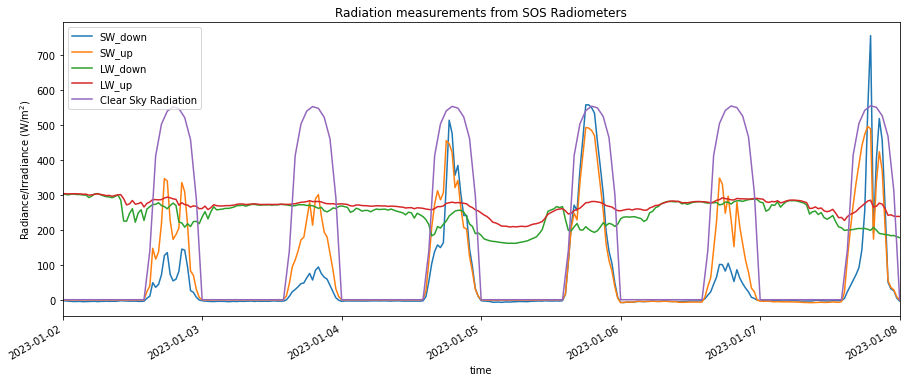

In [140]:
fig, ax = plt.subplots(figsize=(15,6))
# SOS Plot
time_period = slice('2023-1-2','2023-01-08')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['Rsw_in_9m_d'].plot(ax=ax, label='SW_down')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['Rsw_out_9m_d'].plot(ax=ax, label='SW_up')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['LWin'].plot(ax=ax, label='LW_down')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['LWout'].plot(ax=ax, label='LW_up')
clear_sky_rad_df.plot(ax=ax, label='Clear Sky Radiation')
ax.legend()
ax.set_xlim(dt.date(2023,1,2),dt.date(2023,1,8))
ax.set_ylabel('Radiance/Irradiance (W/m$^2$)')
ax.set_title('Radiation measurements from SOS Radiometers')

Comparing shortwave radiation to clear sky radiation shows us that observations are not meeting the potential radiation that could occur if no clouds were present. So we can use a comparison between downwelling shortwave radiation and clear sky radiation models to determine when clouds may be reflecting solar radiation during the day. However, we need to use another technique to cover the overnight period since over this time, there is no solar radiation available.

Text(0.5, 1.0, 'Upward and Downward Longwave radiation from SOS Radiometers')

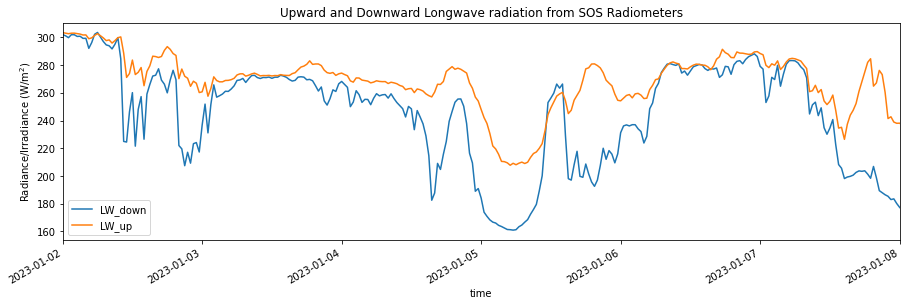

In [139]:
fig, ax = plt.subplots(figsize=(15,4))
# SOS Plot
time_period = slice('2023-1-2','2023-01-08')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['LWin'].plot(ax=ax, label='LW_down')
sos_seb_ds.sel(time=time_period).resample(time='30min').mean()['LWout'].plot(ax=ax, label='LW_up')
ax.legend()
ax.set_xlim(dt.date(2023,1,2),dt.date(2023,1,8))
ax.set_ylabel('Radiance/Irradiance (W/m$^2$)')
ax.set_title('Upward and Downward Longwave radiation from SOS Radiometers')

Upward and downward longwave radiation observations can give us useful insight into cloudy and clearer periods. As a cloud moves overhead during the night or day, it will act like a black-body, absorbing the incoming radiation from the sun and the earth and emitting this energy as longwave radiation, which is related to the temperature of the cloud through the black-body equation. When we see increases in downwelling longwave radiation, we can thus relate this to periods of increased cloud cover (look at Janualy 3 & 4 in the plot above). Drops in downwelling longwave radiation would then indicate clearing skies, as shows overnight on January 5 and during the day on January 8.

Another useful signal, particularly at night over a snowy surface, is the upwelling longwave radiation from the surface. The high emissivity of snow means that a very large fraction of incoming longwave radiation is absorbed and re-emited back to the atmosphere. With no cloud cover at night, the surface will get very cold and we will see large drops in the upwelling longwave radiation signal, similar to downwelling radiation (look at Janualy 5 in the plot above). During a cloudy period overnight, we will not see this same drop (look at Janualy 3 &4) in the plot above. During a clear period during the day, we may see an increase in upwelling longwave radiation as the surface temperature increases, but this same signal would not be seen in the downwelling longwave radiation (see January 8 and late January 5). Lastly, when the upwelling and downwelling values track together during the day, it likely means that cloud cover is overhead since the increases in longwave radiation emitted by the cloud would also lead to increases at the surface in the opposite direction (January 6-7 and 3-4). 

### Problem 3: Dust on snow and albedo
We know that the reflectivity of snow, termed albedo, calculated as outgoing-solar-radiation divided by incoming-solar-radiation, is brightest right after new snowfall and then darkens as snow ages. This occurs both as a process of snow grains rounding and growing and as snow gets dirtier with deposition. In early April, a substantial amount of dust was deposited on our site at Kettle Ponds (see the photo at the top of this page). Using the Kettle Ponds radiation dataset, investigate how albedo changes both with time after a new snowfall event earlier in the winter (no dust) and in mid-April (with dust). How much does dust impact albedo compared to the natural snow aging process?

First we will choose a period to look albedo changes from the natural aging process of snow aiming for a snowy period in late February:

In [99]:
datelist = [dt.datetime.strftime(date, format='%Y%m%d') for date in pd.date_range('20230117','20230125', freq='D')]

sos_datasets = [xr.open_dataset(f'../data/sosnoqc/isfs_{date}.nc')[VARIABLES[0:2]] for date in datelist]
sos_albedo_ds = xr.concat(sos_datasets, dim='time')

In [100]:
sos_albedo_natural_ds = sos_albedo_ds[VARIABLES[0:2]]

time_utc = sos_albedo_natural_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
sos_albedo_natural_ds.coords.update({'LocalTime':tz_corrected})

In [131]:
albedo_natural_filtered = sos_albedo_natural_ds.where(sos_albedo_natural_ds['Rsw_in_9m_d']>200).resample(time='1D').mean()
albedo_natural = (albedo_natural_filtered['Rsw_out_9m_d']/albedo_natural_filtered['Rsw_in_9m_d'])
albedo_natural.name='natual_albedo'

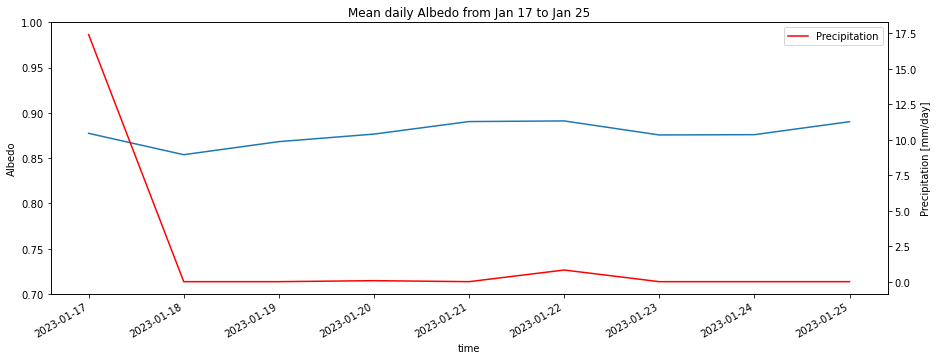

In [138]:
fig, ax = plt.subplots(figsize=(15,5))
albedo_natural.plot(label='albedo',ax=ax)
ax2 = ax.twinx()
daily_precip.loc[dt.date(2023,1,17):dt.date(2023,1,25)].plot(color='red', label='Precipitation', ax=ax2)
ax.set_ylim(0.7,1)
ax.set_ylabel('Albedo')
ax2.set_ylabel('Precipitation [mm/day]')
ax.set_title('Mean daily Albedo from Jan 17 to Jan 25')
ax2.legend()

### Now I will select a period around the dusting event where I will calculate albedo 

In [118]:
datelist = [dt.datetime.strftime(date, format='%Y%m%d') for date in pd.date_range('20230401','20230410', freq='D')]

sos_datasets = [xr.open_dataset(f'../data/sosnoqc/isfs_{date}.nc')[VARIABLES[0:2]] for date in datelist]
sos_albedo_ds = xr.concat(sos_datasets, dim='time')

In [119]:
sos_albedo_dust_ds = sos_albedo_ds[VARIABLES[0:2]]

time_utc = sos_albedo_dust_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
sos_albedo_dust_ds.coords.update({'LocalTime':tz_corrected})

In [124]:
albedo_dust_filtered = sos_albedo_dust_ds.where(sos_albedo_dust_ds['Rsw_in_9m_d']>100).resample(time='1D').mean()
albedo_dust = (albedo_dust_filtered['Rsw_out_9m_d']/albedo_dust_filtered['Rsw_in_9m_d'])
albedo_dust.name='dust_albedo'

Text(0.5, 0, 'Days since Apr 1 (blue) or Jan 17 (orange)')

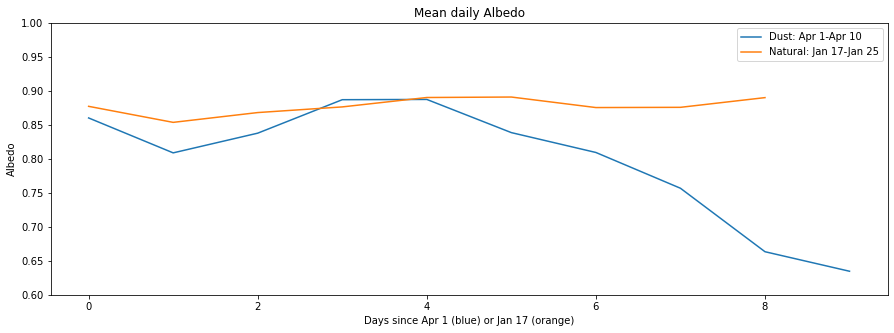

In [136]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(albedo_dust.to_dataframe().reset_index().index, albedo_dust.to_dataframe().reset_index().dust_albedo, label='Dust: Apr 1-Apr 10')
ax.plot(albedo_natural.to_dataframe().reset_index().index, albedo_natural.to_dataframe().reset_index().natual_albedo,label='Natural: Jan 17-Jan 25')
ax.set_ylim(0.6,1)
ax.set_ylabel('Albedo')
ax.set_title('Mean daily Albedo')
ax.legend()
ax.set_xlabel('Days since Apr 1 (blue) or Jan 17 (orange)')

Shortwave albedo was calculated by taking the fraction of outgoing and incoming radiation. I filtered the data by a threshold of 100 W/m2 to avoid the influence of small errors near the end or the start of each day and to avoid calculating values overnight. I then took the mean for each day to get a daily averaged albedo. The albedo during the natural snow period is remarkably consistent across the period with albedo ranging between 0.86 and 0.89. Precipitation mostly occured on January 17, but the natural decay of albedo very slow and was soon hindered by more light snowfall on the folling days.

In stark contrast, the dusting event that occured on April 4th and 5th (here April 4th is day 4 of this time series) had a signifcant impact on albedo and lead to rapid decay toward 0.6 in the following days. The impact from dust on albedo greatly outweighed the impact from natural decay. 